In [1]:
import os
data_dir = 'C:/Workspace/python/Data_Science/dataA/분반(A반)'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f= open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

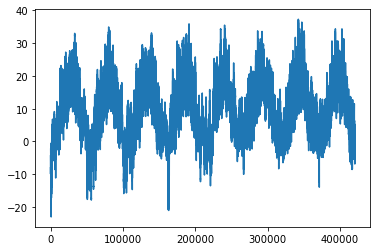

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

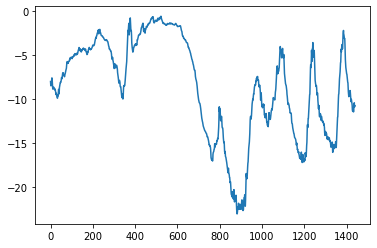

In [ ]:
plt.plot(range(1440), temp[: 1440])

In [4]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

In [5]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, 
              batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for k, row in enumerate(rows):
            indices = range(rows[k] - lookback, rows[k], step)
            samples[k] = data[indices]
            targets[k] = data[rows[k] + delay][1]
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, 
                      delay = delay, min_index = 0, 
                      max_index = 200000, shuffle = True, 
                      step = step, batch_size = batch_size)

val_gen = generator(float_data, lookback = lookback, 
                      delay = delay, min_index = 200001, 
                      max_index = 300000, shuffle = True, 
                      step = step, batch_size = batch_size)

test_gen = generator(float_data, lookback = lookback, 
                      delay = delay, min_index = 300001, 
                      max_index = None, shuffle = True, 
                      step = step, batch_size = batch_size)

val_steps = (30000 - 20001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [7]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.28914828481605137


In [8]:
celsius_mae = 0.29 * std[1]
round(celsius_mae, 2)

2.57

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500,
                    epochs = 20, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 103s 207ms/step - loss: 0.9534 - val_loss: 0.4994
Epoch 2/20
500/500 [==============================] - 99s 199ms/step - loss: 0.3183 - val_loss: 0.2951
Epoch 3/20
500/500 [==============================] - 173s 348ms/step - loss: 0.2723 - val_loss: 0.3138
Epoch 4/20
500/500 [==============================] - 97s 195ms/step - loss: 0.2570 - val_loss: 0.3218
Epoch 5/20
500/500 [==============================] - 101s 202ms/step - loss: 0.2459 - val_loss: 0.3088
Epoch 6/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2396 - val_loss: 0.3272
Epoch 7/20
500/500 [==============================] - 97s 194ms/step - loss: 0.2344 - val_loss: 0.3190
Epoch 8/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2287 - val_loss: 0.3214
Epoch 9/20
500/500 [==============================] - 98s 196ms/step - loss: 0.2237 - val_loss: 0.3209
Epoch 10/20
500/500 [==============================] - 104s 209ms/step

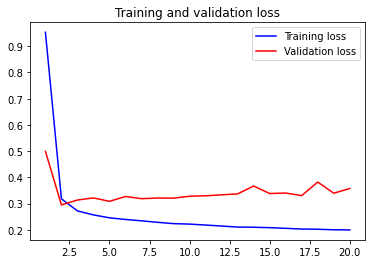

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500,
                    epochs = 20, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 351s 698ms/step - loss: 0.2988 - val_loss: 0.2868
Epoch 2/20
500/500 [==============================] - 318s 638ms/step - loss: 0.2828 - val_loss: 0.2685
Epoch 3/20
500/500 [==============================] - 309s 620ms/step - loss: 0.2785 - val_loss: 0.2681
Epoch 4/20
500/500 [==============================] - 308s 618ms/step - loss: 0.2739 - val_loss: 0.2695
Epoch 5/20
500/500 [==============================] - 299s 599ms/step - loss: 0.2705 - val_loss: 0.2617
Epoch 6/20
500/500 [==============================] - 313s 628ms/step - loss: 0.2660 - val_loss: 0.2606
Epoch 7/20
500/500 [==============================] - 292s 586ms/step - loss: 0.2634 - val_loss: 0.2612
Epoch 8/20
500/500 [==============================] - 315s 632ms/step - loss: 0.2589 - val_loss: 0.2635
Epoch 9/20
500/500 [==============================] - 295s 591ms/step - loss: 0.2545 - val_loss: 0.2684
Epoch 10/20
500/500 [==============================] - 286s 573m

In [ ]:
model.save('C:/Workspace/python/Data_Science/dataA/분반(A반)/Deep Learning for text and sequences/GRU_model.h5')

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout = 0.2, recurrent_dropout = 0.2, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500, epochs = 40, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 358s 709ms/step - loss: 0.3208 - val_loss: 0.2852
Epoch 2/40
500/500 [==============================] - 339s 678ms/step - loss: 0.3034 - val_loss: 0.2751
Epoch 3/40
500/500 [==============================] - 345s 692ms/step - loss: 0.2970 - val_loss: 0.2767
Epoch 4/40
500/500 [==============================] - 329s 660ms/step - loss: 0.2951 - val_loss: 0.2682
Epoch 5/40
500/500 [==============================] - 334s 669ms/step - loss: 0.2900 - val_loss: 0.2797
Epoch 6/40
500/500 [==============================] - 339s 679ms/step - loss: 0.2835 - val_loss: 0.2711
Epoch 7/40
500/500 [==============================] - 340s 680ms/step - loss: 0.2808 - val_loss: 0.2752
Epoch 8/40
500/500 [==============================] - 338s 676ms/step - loss: 0.2760 - val_loss: 0.2702
Epoch 9/40
500/500 [==============================] - 325s 650ms/step - loss: 0.2728 - val_loss: 0.2740
Epoch 10/40
500/500 [==============================] - 322s 644m

In [13]:
model.save('C:/Workspace/python/Data_Science/dataA/분반(A반)/Deep Learning for text and sequences/GRU_model2.h5')

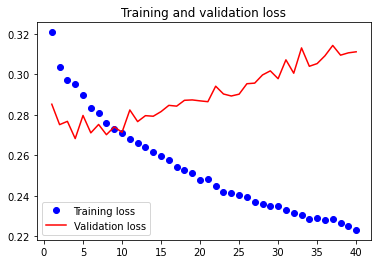

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500, epochs = 40,
                    validation_data = val_gen, validation_steps = val_steps)